In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import explained_variance_score, r2_score, make_scorer
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from scipy.stats import pearsonr
import scipy.stats as stats

import seaborn as sns
import matplotlib.pyplot as plt

import optuna

# 1 Preparation

In [2]:
embedding_file = "test/embeddings_complete.pickle"
expression_file = "datasets/GD660.GeneQuantRPKM.txt.gz"
test_set_file = "datasets/5_fold_cv_split.tsv"
snp_reference_file = "datasets/EUR373.gene.cis.FDR5.all.rs137.txt.gz"

## 1.1 Embeddings

In [3]:
embeddings = pd.read_pickle(embedding_file)
len(embeddings)

10060

In [4]:
# combine 2 embeddings of father and mother for each individual
sample_id = []
gene_id = []
embedding = []
for i in range(0, len(embeddings), 2):
    sid = embeddings[i][0].split(':')[1]
    gid = embeddings[i][0].split(':')[2]
    sample_id.append(sid)
    gene_id.append(gid)
    # combined_embedding = np.concatenate([embeddings[i][1], embeddings[i+1][1]]) # concatenate 2 embeddings.
    combined_embedding = np.array(embeddings[i][1] + embeddings[i+1][1]) # element-wise sum of 2 embeddings
    embedding.append(combined_embedding)
df = pd.DataFrame({"sample_id": sample_id, "gene_id": gene_id, "embedding": embedding})

In [5]:
df.head()

,sample_id,gene_id,embedding
0,NA20795,ENSG00000198502.5,"[0.020763932, -0.0043599964, 0.018072195, -0.0..."
1,HG00260,ENSG00000214425.1,"[0.034569502, 0.024124226, -0.06553179, -0.017..."
2,HG01632,ENSG00000176681.9,"[-0.0912664, 0.07260499, -0.07260455, 0.113591..."
3,HG00173,ENSG00000238083.3,"[0.08705197, 0.056551743, 0.033424325, -0.0829..."
4,HG00178,ENSG00000229450.2,"[0.14517619, -0.016366798, -0.0096497275, -0.0..."


## 1.2 Expression Data

In [6]:
expression = pd.read_csv(expression_file, sep="\t")
expression.head()

,TargetID,Gene_Symbol,Chr,Coord,HG00096.1.M_111124_6,HG00097.7.M_120219_2,HG00099.1.M_120209_6,HG00099.5.M_120131_3,HG00100.2.M_111215_8,HG00101.1.M_111124_4,...,NA20810.2.M_111215_7,NA20811.1.M_111124_5,NA20812.2.M_111216_6,NA20813.5.M_120131_1,NA20814.2.M_111215_6,NA20815.5.M_120131_5,NA20816.3.M_120202_7,NA20819.3.M_120202_2,NA20826.1.M_111124_1,NA20828.2.M_111216_8
0,ENSG00000225538.1,ENSG00000225538.1,11,55850277,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.0000,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000,0.03876,0.00000
1,ENSG00000237851.1,ENSG00000237851.1,6,143109260,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.0000,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000,0.00000,0.00000
2,ENSG00000243765.1,ENSG00000243765.1,15,58442766,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.0000,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000,0.00000,0.00000
3,ENSG00000257527.1,ENSG00000257527.1,16,18505708,0.70561,0.66697,0.64004,0.26195,0.34695,1.49208,...,0.87085,0.9495,0.95837,0.51002,0.29422,0.2296,0.58671,0.27674,0.53630,0.17139
4,ENSG00000212855.5,ENSG00000212855.5,Y,9578193,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.0000,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000,0.00000,0.00000


In [7]:
expression = expression[expression["Gene_Symbol"].isin(df["gene_id"].values)]
expression = pd.melt(expression, id_vars=["TargetID", "Gene_Symbol", "Chr", "Coord"], var_name="sample_id", value_name="expression")
expression["sample_id"] = expression["sample_id"].str.split(".", expand=True)[0] + "." + expression["sample_id"].str.split(".", expand=True)[1]

In [18]:
pd.read_csv(test_set_file, sep="\t")

,sample_id,patient,gene_id,test_split
0,NA20795.5,NA20795,ENSG00000198502.5,3
1,HG00260.5,HG00260,ENSG00000214425.1,2
2,HG00173.3,HG00173,ENSG00000238083.3,2
3,HG00178.4,HG00178,ENSG00000229450.2,2
4,HG00158.1,HG00158,ENSG00000179344.11,4
...,...,...,...,...
4785,NA20774.7,NA20774,ENSG00000196735.6,5
4786,HG00267.4,HG00267,ENSG00000232629.4,2
4787,HG00366.4,HG00366,ENSG00000196735.6,3
4788,HG00379.5,HG00379,ENSG00000176681.9,3


In [24]:
test_set = pd.read_csv(test_set_file, sep="\t")
data = pd.merge(test_set, expression, left_on=["gene_id", "sample_id"], right_on=["Gene_Symbol", "sample_id"])

In [28]:
data = pd.merge(df, data, left_on=["sample_id", "gene_id"], right_on=["patient", "gene_id"])
data = data.drop(columns=["sample_id_x", "Chr", "TargetID", "Coord", "Gene_Symbol"])
data.rename(columns={"sample_id_y":"sample_id"}, inplace=True)

In [37]:
data.head()

,gene_id,embedding,sample_id,patient,test_split,expression
0,ENSG00000198502.5,"[0.020763932, -0.0043599964, 0.018072195, -0.0...",NA20795.5,NA20795,3,177.86778
1,ENSG00000214425.1,"[0.034569502, 0.024124226, -0.06553179, -0.017...",HG00260.5,HG00260,2,0.48644
2,ENSG00000238083.3,"[0.08705197, 0.056551743, 0.033424325, -0.0829...",HG00173.3,HG00173,2,6.83944
3,ENSG00000229450.2,"[0.14517619, -0.016366798, -0.0096497275, -0.0...",HG00178.4,HG00178,2,0.08522
4,ENSG00000179344.11,"[0.05826454, 0.0701687, 0.11973057, -0.0561387...",HG00158.1,HG00158,4,318.19590


# 2 Linear Regression

Add standard scaling of the embeddings, since this is assumed by many objective functions (e.g. RBF kernel of SVMs or L1/L2 regularizers of linear models), see https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html.

In [40]:
splits_train = {}
splits_test = {}
for i in range(1, 6):
    r_values_train = {}
    r_values_test = {}
    for gene in data.gene_id.unique():
        # extract data
        gene_df = data[data.gene_id == gene]
        gene_df_train = gene_df[gene_df.test_split != i]
        gene_df_test = gene_df[gene_df.test_split == i]
        X_train = np.array(gene_df_train["embedding"].values.tolist())
        X_test = np.array(gene_df_test["embedding"].values.tolist())
        # Standard scale the data
        scaler = StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train)
        # scaler = StandardScaler().fit(X_test)
        X_test = scaler.transform(X_test)
        y_train = np.array(gene_df_train.expression)
        y_test = np.array(gene_df_test.expression)

        # train model
        model = LinearRegression().fit(X_train, y_train)

        # evaluate model on test set
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        r_values_train[gene] = pearsonr(y_train, y_pred_train)[0]
        r_values_test[gene] = pearsonr(y_test, y_pred_test)[0]

        # plot results on training set
        # plt.scatter(y_train, y_pred_train)
        # plt.title(f"gene {gene} y_true vs. y_pred training set")
        # plt.show()
        # plt.scatter(y_test, y_pred_test)
        # plt.title(f"gene {gene} y_true vs. y_pred test set")
        # plt.show()
    splits_train[i] = r_values_train
    splits_test[i] = r_values_test

In [41]:
splits_test

{1: {'ENSG00000198502.5': 0.09069044788291139,
  'ENSG00000214425.1': 0.07427392207971828,
  'ENSG00000238083.3': 0.11173176356315807,
  'ENSG00000229450.2': 0.07334434012761687,
  'ENSG00000179344.11': 0.07205693527619554,
  'ENSG00000237541.3': 0.36042772865040457,
  'ENSG00000196126.6': -0.11741397701850687,
  'ENSG00000196735.6': 0.23122187433245306,
  'ENSG00000176681.9': -0.05210414377460923,
  'ENSG00000232629.4': 0.33158976291026193},
 2: {'ENSG00000198502.5': 0.15126376507986744,
  'ENSG00000214425.1': -0.012694491150648829,
  'ENSG00000238083.3': 0.05901325890835674,
  'ENSG00000229450.2': 0.007841746972888135,
  'ENSG00000179344.11': 0.17472084579073036,
  'ENSG00000237541.3': 0.10770690415653798,
  'ENSG00000196126.6': 0.12551769404265067,
  'ENSG00000196735.6': 0.3367392494476019,
  'ENSG00000176681.9': 0.13403792030697007,
  'ENSG00000232629.4': 0.08466286008265045},
 3: {'ENSG00000198502.5': 0.0719184193709167,
  'ENSG00000214425.1': 0.01487753136417459,
  'ENSG000002380

In [35]:
# TODO: mean per gene, then overall mean and SD (?)
results = [v for v in r_values_test.values()]
print(f"mean: {np.mean(results)}")
print(f"SD: {np.std(results)}")

mean: 0.01997587581087238
SD: 0.14222750493784117


In [13]:
train_df = pd.DataFrame({"gene_id": r_values_train.keys(), "r_values": r_values_train.values()})
test_df = pd.DataFrame({"gene_id": r_values_test.keys(), "r_values": r_values_test.values()})

# 3 Comparison to prediction based on single SNPs

In [27]:
reference = pd.read_csv(snp_reference_file, sep="\t")
reference = reference[reference.GENE_ID.isin(data.gene_id.unique())]
reference.GENE_ID = reference.GENE_ID.astype('category')
reference["abs_rvalue"] = np.abs(reference.rvalue.values)
reference.head()

,SNP_ID,ID,GENE_ID,PROBE_ID,CHR_SNP,CHR_GENE,SNPpos,TSSpos,distance,rvalue,pvalue,log10pvalue,abs_rvalue
55450,rs10020034,-,ENSG00000229450.2,ENSG00000229450.2,4,4,120294331.0,120299287,4956.0,0.548974,1.079312e-30,29.966853,0.548974
55451,rs3955380,-,ENSG00000229450.2,ENSG00000229450.2,4,4,120334410.0,120299287,35123.0,0.547157,1.832933e-30,29.736854,0.547157
55452,rs28403131,-,ENSG00000229450.2,ENSG00000229450.2,4,4,120285806.0,120299287,13481.0,0.545653,2.834881e-30,29.547465,0.545653
55453,rs79262354,-,ENSG00000229450.2,ENSG00000229450.2,4,4,120338335.0,120299287,39048.0,0.545126,3.300820e-30,29.481378,0.545126
55454,rs78958430,-,ENSG00000229450.2,ENSG00000229450.2,4,4,120338339.0,120299287,39052.0,0.544934,3.488677e-30,29.457339,0.544934


In [28]:
median_expr_per_gene = pd.DataFrame(expression.groupby("Gene_Symbol")["expression"].median())
median_expr_per_gene = median_expr_per_gene.reset_index()

In [34]:
best_snp_per_gene = reference.groupby("GENE_ID")["rvalue"].max().tolist()
print(f"mean: {np.mean(best_snp_per_gene)}")
print(f"SD: {np.std(best_snp_per_gene)}")

mean: 0.5104532896135584
SD: 0.10530854342735298


In [29]:
gene_order = median_expr_per_gene.sort_values(by="expression")["Gene_Symbol"].to_list()

reference.GENE_ID = reference.GENE_ID.cat.set_categories(gene_order)
train_df.gene_id = train_df.gene_id.astype("category")
train_df.gene_id = train_df.gene_id.cat.set_categories(gene_order)
test_df.gene_id = test_df.gene_id.astype("category")
test_df.gene_id = test_df.gene_id.cat.set_categories(gene_order)
median_expr_per_gene.Gene_Symbol = median_expr_per_gene.Gene_Symbol.astype("category")
median_expr_per_gene.Gene_Symbol = median_expr_per_gene.Gene_Symbol.cat.set_categories(gene_order)

reference = reference.sort_values(by = 'GENE_ID')
train_df = train_df.sort_values(by = 'gene_id')
test_df = test_df.sort_values(by = 'gene_id')
median_expr_per_gene = median_expr_per_gene.sort_values(by = "Gene_Symbol")

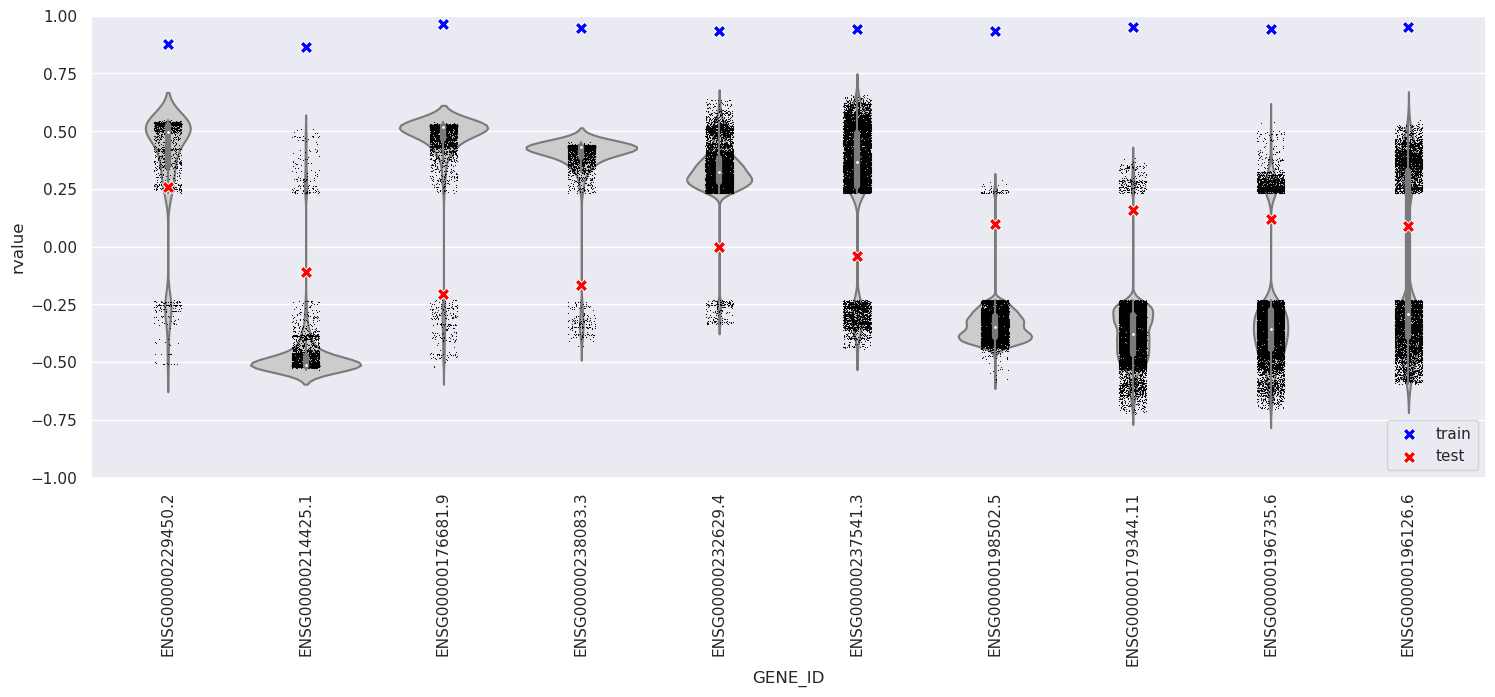

In [30]:
sns.set(rc={'figure.figsize':(18,6)})

sns.violinplot(x = "GENE_ID", y ="rvalue", data=reference, color="0.8", zorder=0)
sns.stripplot(x = "GENE_ID", y ="rvalue", data=reference, color="0.0", size=0.8, zorder=1) 
sns.scatterplot(x = "gene_id", y="r_values", data=train_df, color="blue", s=80, marker="X", zorder=2, label="train")
sns.scatterplot(x = "gene_id", y="r_values", data=test_df, color="red", s=80, marker="X", zorder=3, label="test")

plt.ylim(-1.0, 1.0)
plt.xticks(rotation = 90)
plt.legend(loc='lower right')
plt.show()

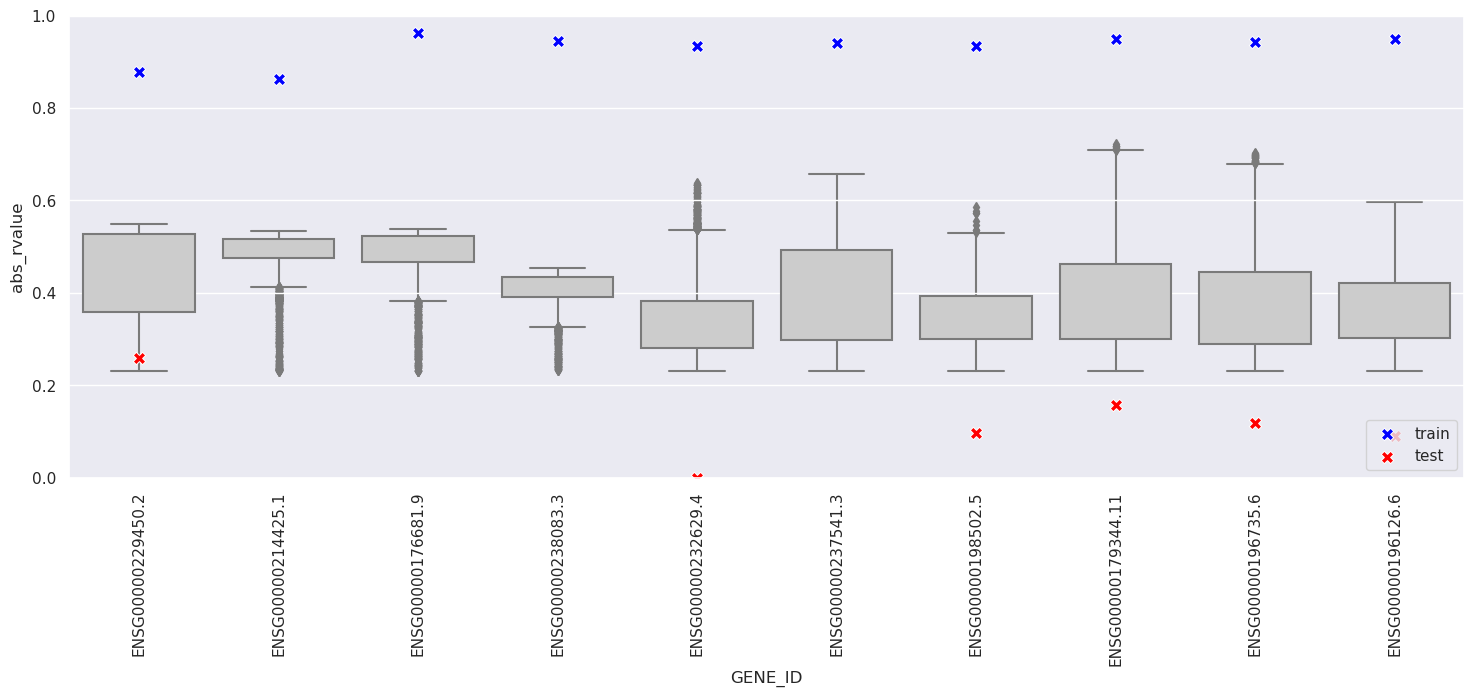

In [31]:
sns.boxplot(x = "GENE_ID", y ="abs_rvalue", data=reference, color="0.8", zorder=0) 
sns.scatterplot(x = "gene_id", y="r_values", data=train_df, color="blue", s=80, marker="X", zorder=1, label="train")
sns.scatterplot(x = "gene_id", y="r_values", data=test_df, color="red", s=80, marker="X", zorder=2, label="test")

plt.ylim(0.0, 1.0)
plt.xticks(rotation = 90)
plt.legend(loc='lower right')
plt.show()

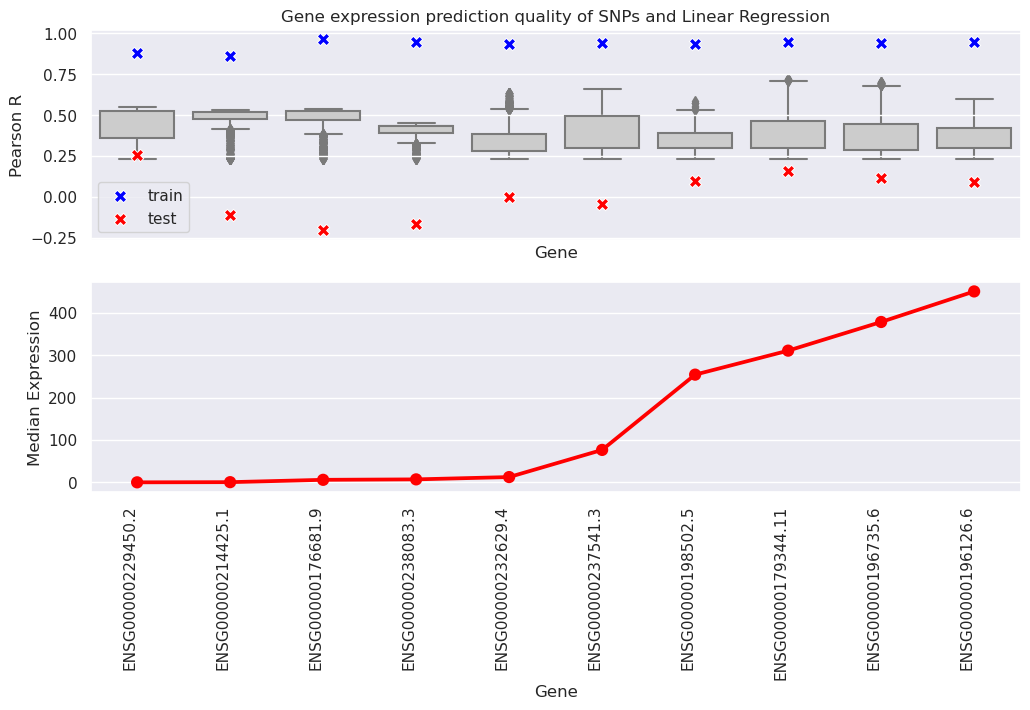

In [33]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 6), sharex=True)

ax1.set_title("Gene expression prediction quality of SNPs and Linear Regression")

sns.boxplot(x = "GENE_ID", y ="abs_rvalue", data=reference, color="0.8", zorder=0, ax=ax1) 
sns.scatterplot(x = "gene_id", y="r_values", data=train_df, color="blue", s=80, marker="X", zorder=1, label="train", ax=ax1)
sns.scatterplot(x = "gene_id", y="r_values", data=test_df, color="red", s=80, marker="X", zorder=2, label="test", ax=ax1)
# plt.ylim(0.0, 1.0)
ax1.set_xlabel("Gene")
ax1.set_ylabel("Pearson R")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, horizontalalignment='right')

sns.pointplot(data=median_expr_per_gene, x="Gene_Symbol", y="expression", color="red", ax=ax2)
ax2.set_ylabel("Median Expression")
ax2.set_xlabel("Gene")
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90, horizontalalignment='right')

plt.show()